In [1]:
x_train = catalog.load("momogp_parkinsons.x_train")
y_train = catalog.load("momogp_parkinsons.y_train")

x_test = catalog.load("momogp_parkinsons.x_test")
y_test = catalog.load("momogp_parkinsons.y_test")

2021-12-16 10:03:01,856 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.x_train` (CSVDataSet)...
2021-12-16 10:03:01,866 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.y_train` (CSVDataSet)...
2021-12-16 10:03:01,869 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.x_test` (CSVDataSet)...
2021-12-16 10:03:01,873 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.y_test` (CSVDataSet)...


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal
from scipy.stats import multivariate_normal


ngb = NGBRegressor(
    Dist= MultivariateNormal(2), verbose=True, n_estimators=500, natural_gradient=True
)
ngb.fit(x_train, y_train)


[iter 0] loss=6.1630 val_loss=0.0000 scale=0.5000 norm=5.6576
[iter 100] loss=6.0595 val_loss=0.0000 scale=0.2500 norm=2.7430
[iter 200] loss=6.0330 val_loss=0.0000 scale=0.2500 norm=2.7042
[iter 300] loss=6.0034 val_loss=0.0000 scale=0.5000 norm=5.3362
[iter 400] loss=5.9564 val_loss=0.0000 scale=0.2500 norm=2.6229


NGBRegressor(Dist=<class 'ngboost.distns.multivariate_normal.MultivariateNormal.<locals>.MVN'>,
             random_state=RandomState(MT19937) at 0x7FA1E5C27150)

In [3]:
def NLL(dists, y):
    N = y.shape[0]
    nlls = [-dists[i].logpdf(y[i, :]) for i in range(N)]
    return nlls

In [4]:
y_dist = ngb.pred_dist(x_train)

np.mean(NLL(y_dist.scipy_distribution(), y_train.values))

5.936457702207162

In [5]:
y_test_dist = ngb.pred_dist(x_test)

np.mean(NLL(y_test_dist.scipy_distribution(), y_test.values))

6.011811735348459

In [6]:
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost

In [7]:
flow = ContinuousNormalizingFlow(
    input_dim=2,
    hidden_dims=(80, 80, 80, 40),
    context_dim=100,
    conditional=True,
)

tree = EmbeddableCatBoostPriorNormal(loss_function="MultiRMSE", depth=2, num_trees=300)

tfb = TreeFlowBoost(flow_model=flow, tree_model = tree, embedding_size=100)

In [10]:
tfb.fit(x_train.values, y_train.values)

0:	learn: 13.3286580	total: 732us	remaining: 219ms
1:	learn: 13.3134963	total: 1.46ms	remaining: 218ms
2:	learn: 13.3032265	total: 2.11ms	remaining: 209ms
3:	learn: 13.2859781	total: 2.78ms	remaining: 205ms
4:	learn: 13.2733332	total: 3.43ms	remaining: 203ms
5:	learn: 13.2617905	total: 4.09ms	remaining: 201ms
6:	learn: 13.2465778	total: 4.76ms	remaining: 199ms
7:	learn: 13.2276935	total: 5.39ms	remaining: 197ms
8:	learn: 13.2040213	total: 6.04ms	remaining: 195ms
9:	learn: 13.1902303	total: 6.65ms	remaining: 193ms
10:	learn: 13.1785136	total: 7.3ms	remaining: 192ms
11:	learn: 13.1604722	total: 7.88ms	remaining: 189ms
12:	learn: 13.1395249	total: 8.48ms	remaining: 187ms
13:	learn: 13.1278825	total: 9.07ms	remaining: 185ms
14:	learn: 13.1093636	total: 9.65ms	remaining: 183ms
15:	learn: 13.0891884	total: 10.2ms	remaining: 181ms
16:	learn: 13.0763295	total: 10.8ms	remaining: 180ms
17:	learn: 13.0608783	total: 11.4ms	remaining: 179ms
18:	learn: 13.0530751	total: 12ms	remaining: 177ms
19:	lea

TreeFlowBoost(embedding_size=100,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7fa120263e48>,
              tree_model=<src.probabilistic_flow_boosting.tfboost.tree.ecatboost.EmbeddableCatBoostPriorNormal object at 0x7fa120263da0>)

In [11]:
-np.mean(tfb.log_prob(x_train.values, y_train.values))

4.859187

In [12]:
-np.mean(tfb.log_prob(x_test.values, y_test.values))

5.2404265

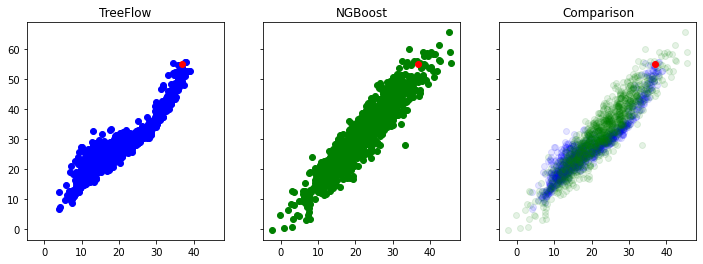

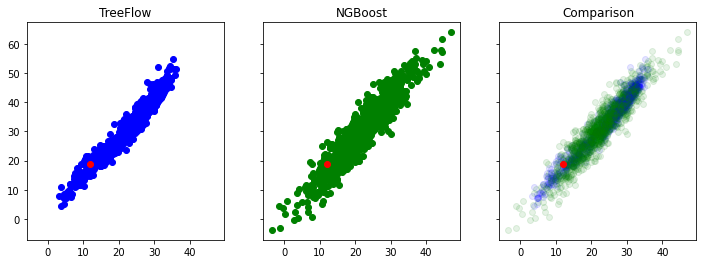

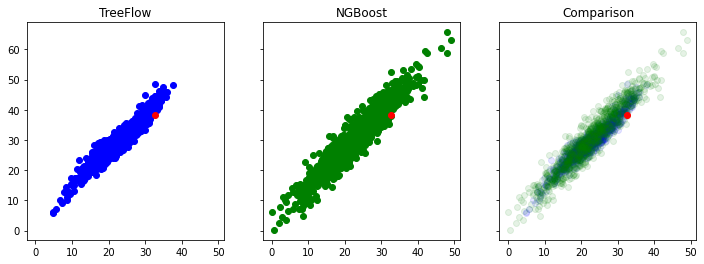

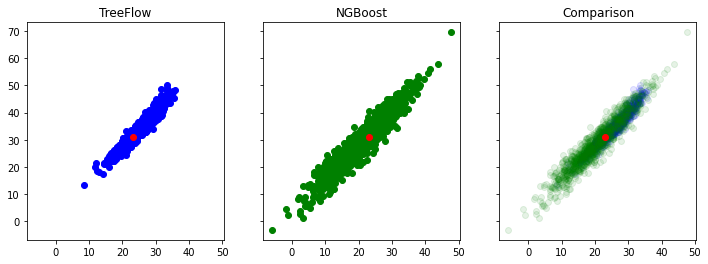

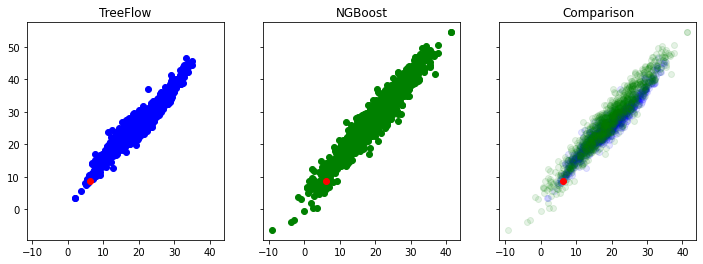

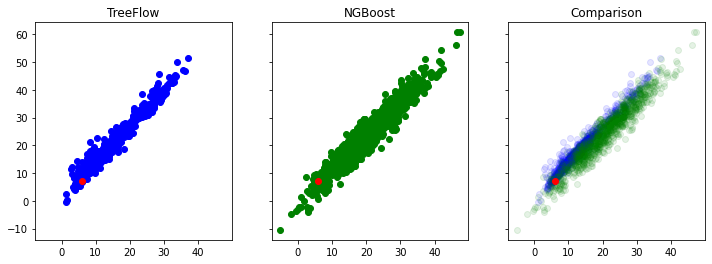

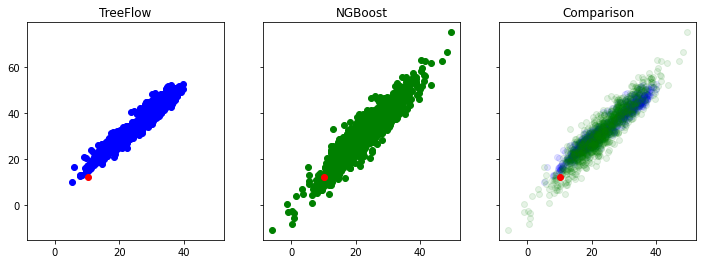

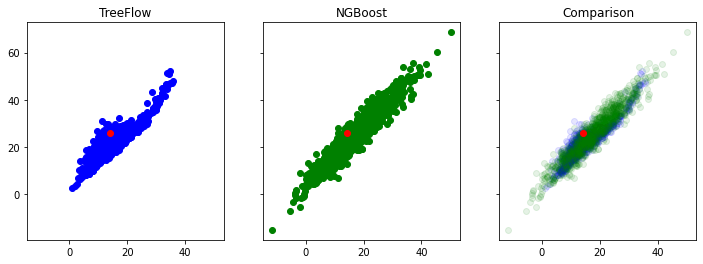

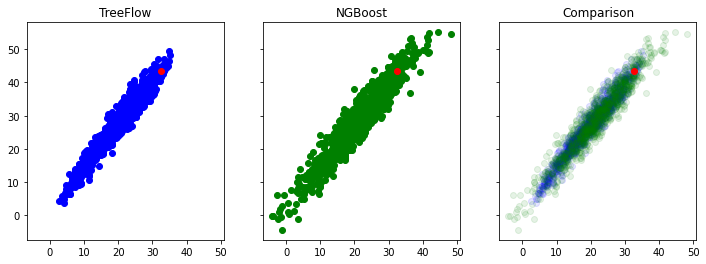

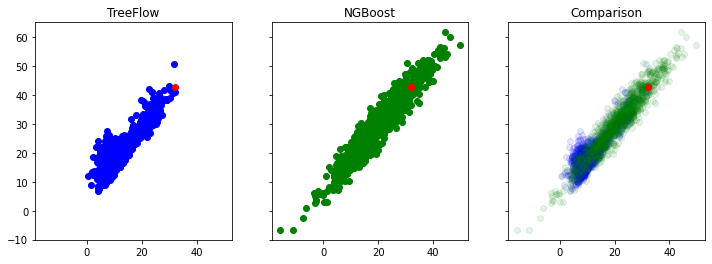

In [58]:
for i in range(10, 20):
    samples_tfb = tfb.sample(x_test.values[i:i+1, :], num_samples=1000)
    samples_ngb = np.vstack(ngb.pred_dist(x_test.values[i:i+1, :]).sample(1000))

    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
    ax[0].scatter(samples_tfb[0, :, 0], samples_tfb[0, :, 1], color = 'blue', label = 'TreeFlow')
    ax[0].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red')
    ax[0].set_title('TreeFlow')
    
    ax[1].scatter(samples_ngb[:, 0], samples_ngb[:, 1], color = 'green', label = 'NGBoost')
    ax[1].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red')
    ax[1].set_title('NGBoost')
    
    ax[2].scatter(samples_tfb[0, :, 0], samples_tfb[0, :, 1], color = 'blue', label = 'TreeFlow', alpha=0.1)
    ax[2].scatter(samples_ngb[:, 0], samples_ngb[:, 1], color = 'green', label = 'NGBoost', alpha=0.1)
    ax[2].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red')
    ax[2].set_title('Comparison')

    # plt.legend()
    plt.show()